# Self-Driving Car Engineer Nanodegree

In [193]:
import numpy as np
import pandas as pd
import seaborn as sbs
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.utils import shuffle

%matplotlib inline

---
## 1. Load The Data

In [194]:
# Load pickled data
import pickle

# TODO: Fill this in based on where you saved the training and testing data

training_file = "data/train.p"
validation_file = "data/valid.p"
testing_file = "data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## 2. Dataset Summary & Exploration
 

In [195]:
n_train = y_train.shape[0]

n_validation = y_train.shape[0]

n_test = y_train.shape[0]

image_shape = X_test[0].shape

n_classes = np.unique(y_train).shape[0]

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Number of validation examples =", n_validation)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 34799
Number of validation examples = 34799
Image data shape = (32, 32, 3)
Number of classes = 43


### Include an exploratory visualization of the dataset

In [196]:
def show_images(images_to_show, row=3, col=2, fig_size=(15, 6)):
    f, axes = plt.subplots(row, col)
    f.set_size_inches(fig_size)
    for y in range(0, row):
        for x in range(0, col):
            ax = axes[y, x]
            ax.grid(b=None)
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            if y * col + x < len(images_to_show):
                ax.imshow(images_to_show[y * col + x][1])

In [197]:
import random

images_examples = {}
for x, y in zip(X_train, y_train):
    if y in images_examples.keys():
        if random.randint(0, 2) == 0:
            images_examples[y] = x
    else:
        images_examples[y] = x
    
import operator
traffic_signs = sorted(images_examples.items(), key=operator.itemgetter(0))

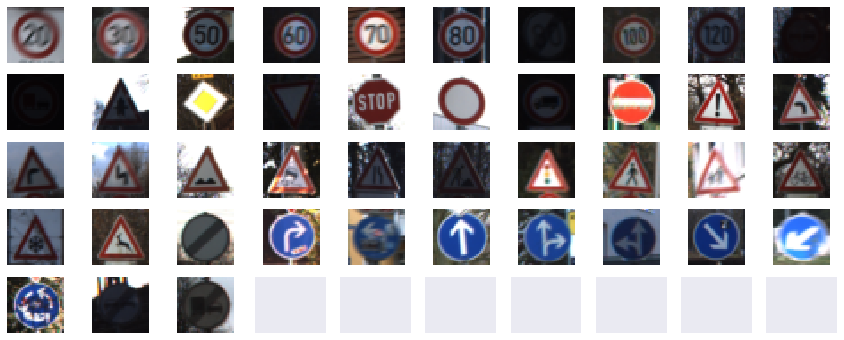

In [198]:
show_images(traffic_signs, row=5, col=10)

Check if the number of classes within sets is well balanced

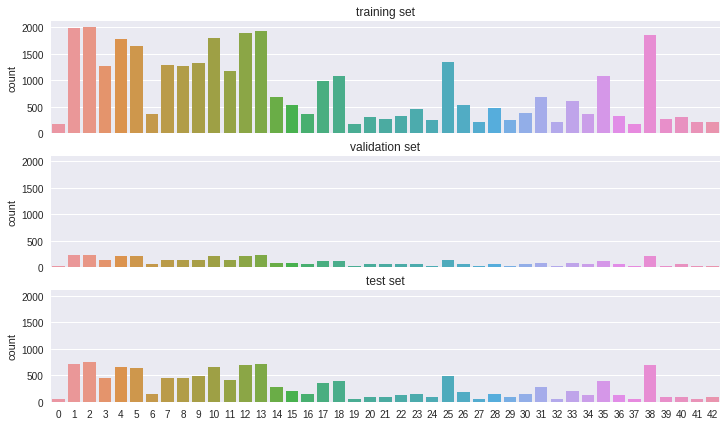

In [199]:
f, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, sharey=True)
sbs.countplot(x=y_train, ax=ax1)
ax1.title.set_text('training set')
sbs.countplot(x=y_valid, ax=ax2)
ax2.title.set_text('validation set')
sbs.countplot(x=y_test, ax=ax3)
ax3.title.set_text('test set')
f.set_size_inches((12, 7))
plt.show()

In [200]:
label_counts = pd.DataFrame(data = {'label' : y_train})
label_counts['label'].value_counts().describe()

count      43.000000
mean      809.279070
std       626.750855
min       180.000000
25%       285.000000
50%       540.000000
75%      1275.000000
max      2010.000000
Name: label, dtype: float64

## 3. Preprocessing

As seen above the training set is not well balaned and there is a big discrapency between some of the classes. In example class 0 has roughly 250 instances meanwhile class 1 roughly 2k instances.

In [201]:
import imgaug as ia
import random
from imgaug import augmenters as iaa

In [202]:
import cv2
import random

def rotate_img(img, s_angle=-30, end_angle=30):
    range = end_angle - s_angle
    rand_range = random.randint(0, range)
    rows, cols, _ = img.shape
    M = cv2.getRotationMatrix2D((cols/2,rows/2), s_angle + rand_range, 1)
    return cv2.warpAffine(img,M,(cols,rows))

def scale_img(img, scale=1.0):
    return cv2.resize(img, (0, 0), fx=scale, fy=scale, interpolation = cv2.LINEAR)

def translate(img, vx=0.0, vy=0.0):
    rows, cols, _ = img.shape
    M = np.float32([[1,0,vx],[0,1,vy]])
    return cv2.warpAffine(img,M,(cols,rows))

def brightness(img, value=0):
    tmp = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    # for positive values make sure it doesn't exceed 255
    #tmp[:,:,2] = np.where((255 - tmp[:,:,2]) < value, 255, tmp[:,:,2] + value)
    # value might be also negative
    #tmp[:,:,2] = np.where((tmp[:,:,2]) < 0, 0, tmp[:,:,2])
    tmp = np.clip(tmp, 0, 255)
    tmp = cv2.cvtColor(tmp, cv2.COLOR_HSV2RGB)
    return tmp

def blur(img, sigma):
    return cv2.GaussianBlur(img, (5, 5), sigma)

def noise(img, sigma):
    some_noise = np.random.randn(img.shape[0], img.shape[1], img.shape[2])
    some_noise = sigma * some_noise
    noisy_img = img + some_noise
    noisy_img = np.clip(noisy_img, 0, 255)
    return noisy_img.astype('uint8')

def augment_image(img):
    sigma = random.gauss(0.0, 15.0)
    img = noise(img, sigma)
    sigma = random.gauss(1.0, 0.2)
    img = blur(img, sigma)
    #img = scale_img(img, scale)
    #print(img.shape)
    
    v = random.randint(-3, 3)
    img = translate(img, v, v)
    
    value = random.randint(-80, 80)
    img = brightness(img, value)
    
    img = rotate_img(img)
    #print(img.shape)
    return img

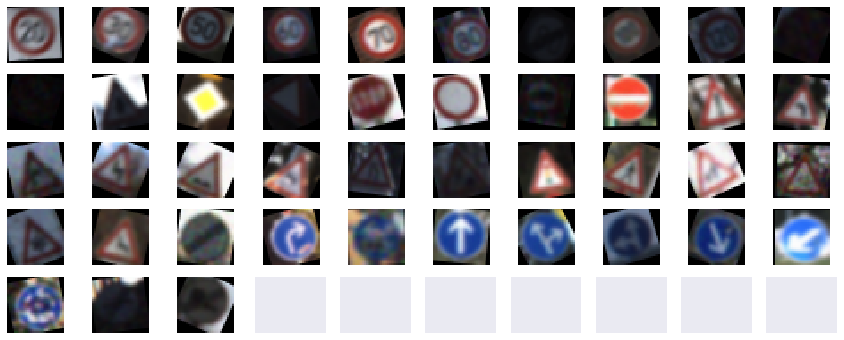

In [203]:
augmented = [(img[0], augment_image(img[1])) for img in traffic_signs]
show_images(augmented, row=5, col=10)

In [204]:
def print_image(img):
    f, axes = plt.subplots(1, 1)
    f.set_size_inches((1,1))
    plt.imshow(img)
    axes.grid(b=None)

In [205]:
def get_images_with_label(X, y, label):
    images = []
    for img_x, lab_y in zip(X, y):
        if lab_y == label:
            images.append(img_x)
    return np.asarray(images)

for y in set(y_train):
    print("label: ", y)
    while(1):
        label_counts = pd.DataFrame(data = {'label' : y_train})
        label_count = label_counts[label_counts.label == y].shape[0]
        if label_count > 800:
            break
        images_with_label = get_images_with_label(X_train, y_train, y)
        for image in images_with_label:
            img = augment_image(image)
            X_train = np.append(X_train, img.reshape(1, 32, 32, 3), axis=0)
            y_train = np.append(y_train, np.asarray(y).reshape(1), axis=0)

label:  0
label:  1
label:  2
label:  3
label:  4
label:  5
label:  6
label:  7
label:  8
label:  9
label:  10
label:  11
label:  12
label:  13
label:  14
label:  15
label:  16
label:  17
label:  18
label:  19
label:  20
label:  21
label:  22
label:  23
label:  24
label:  25
label:  26
label:  27
label:  28
label:  29
label:  30
label:  31
label:  32
label:  33
label:  34
label:  35
label:  36
label:  37
label:  38
label:  39
label:  40
label:  41
label:  42


In [206]:
X_train.shape, y_train.shape

((56338, 32, 32, 3), (56338,))

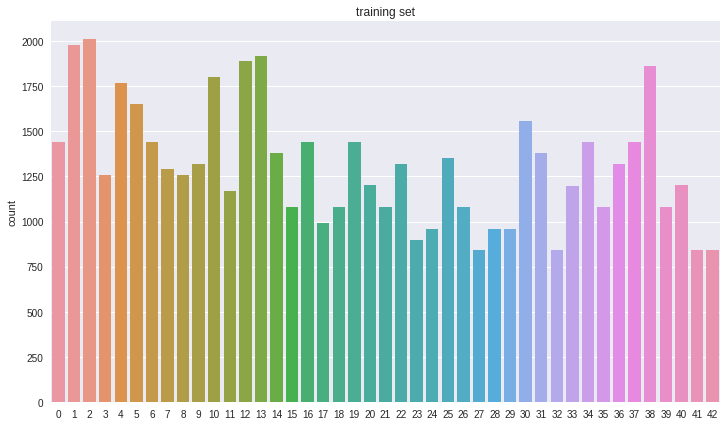

In [207]:
f, ax1 = plt.subplots(1, sharex=True, sharey=True)
sbs.countplot(x=y_train, ax=ax1)
ax1.title.set_text('training set')
f.set_size_inches((12, 7))
plt.show()

In [208]:
X_train.shape, y_train.shape

((56338, 32, 32, 3), (56338,))

In [209]:
from sklearn.preprocessing import minmax_scale

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])


X_train = rgb2gray(X_train)
X_valid = rgb2gray(X_valid)
X_test = rgb2gray(X_test)

X_train = np.expand_dims(X_train, 3)
X_valid = np.expand_dims(X_valid, 3)
X_test = np.expand_dims(X_test, 3)

X_train = (X_train - np.full(X_train.shape, 128, dtype='float32'))/128
X_valid = (X_valid - np.full(X_valid.shape, 128, dtype='float32'))/128
X_test = (X_test - np.full(X_test.shape, 128, dtype='float32'))/128

## 4. Define Model Architectures

For the purpose of this project let's compare the performace of the LeNet (baseline) from the task description and AlexNet - another famous neural network architecture. 

In [210]:
from tensorflow.contrib.layers import flatten


def conv2d(x, f_size, no_filters, stride, name, mu = 0, sigma = 0.1, padding='VALID'):
    no_channels = int(x.get_shape()[-1])
    
    with tf.variable_scope(name) as scope:
        weights = tf.Variable(
            tf.truncated_normal(shape=(f_size, f_size, no_channels, no_filters),
            mean = mu, stddev = sigma
        ))
        biases = tf.Variable(tf.zeros(no_filters))
        conv = tf.nn.conv2d(x, weights, strides = [1, stride, stride, 1], padding = padding) + biases
        
        return tf.nn.relu(conv, name = scope.name)


def fc(x, ins, outs, name, is_relu=True, mu = 0, sigma = 0.1):
    with tf.variable_scope(name) as scope:
        weights =  tf.Variable(tf.truncated_normal(shape=(ins, outs), mean = mu, stddev = sigma))
        biases = tf.Variable(tf.zeros(outs))
    
        act = tf.matmul(x, weights) + biases
        
        if is_relu:
            return tf.nn.relu(act)
        return act
    
def lrn(x, radius, alpha, beta, name, bias=1.0):
      return tf.nn.local_response_normalization(x, depth_radius = radius,
                                            alpha = alpha, beta = beta,
                                            bias = bias, name = name)


def MyNet(x, keep_prob, mu = 0, sigma = 0.1):
    
    # Layer 1: Convolution
    conv1 = conv2d(x, 7, 16, 1, 'conv1')
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    conv1 = lrn(conv1, 2, 2e-05, 0.75, name = 'norm2')
    
    # Layer 2: Convolution
    conv2 = conv2d(conv1, 5, 48, 1, 'conv2')
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    conv2 = lrn(conv2, 2, 2e-05, 0.75, name = 'norm2')

    # Flatten
    fc0 = flatten(conv2)
    fc0 = tf.nn.dropout(fc0, keep_prob)

    # Layer 3: Fully Connected
    fc1 = fc(fc0, 768, 300, 'fc1')
    fc1 = tf.nn.dropout(fc1, keep_prob)
    
    # Layer 4: Fully Connected
    fc2 = fc(fc1, 300, 200, 'fc2')
    fc2 = tf.nn.dropout(fc2, keep_prob)
 
    # Layer 5: Fully Connected
    fc3 = fc(fc2, 200, 100, 'fc3')
    fc3 = tf.nn.dropout(fc3, keep_prob)

    # Layer 6: Fully Connected
    return fc(fc3, 100, 43, 'logits', False)

In [211]:
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
keep_prob = tf.placeholder(tf.float32)
one_hot_y = tf.one_hot(y, 43)

In [212]:
rate = 0.001
EPOCHS = 20
BATCH_SIZE = 128

In [213]:
#eights = tf.get_variable('weights', collections=['variables'])

In [214]:
logits = MyNet(x, keep_prob)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

In [ ]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [ ]:
with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.5})
            
        validation_accuracy = evaluate(X_valid, y_valid)
        training_accuracy = evaluate(X_train, y_train)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print("Training Accuracy = {:.3f}".format(training_accuracy))
        print()
        
    print("Test set accuracy: ", evaluate(X_test, y_test))
    saver.save(sess, './lenet')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.455
Training Accuracy = 0.352

EPOCH 2 ...
Validation Accuracy = 0.756
Training Accuracy = 0.647

EPOCH 3 ...
Validation Accuracy = 0.831
Training Accuracy = 0.753

EPOCH 4 ...
Validation Accuracy = 0.861
Training Accuracy = 0.800

EPOCH 5 ...
Validation Accuracy = 0.906
Training Accuracy = 0.843

EPOCH 6 ...
Validation Accuracy = 0.913
Training Accuracy = 0.863

EPOCH 7 ...
Validation Accuracy = 0.918
Training Accuracy = 0.874

EPOCH 8 ...
Validation Accuracy = 0.919
Training Accuracy = 0.881

EPOCH 9 ...
Validation Accuracy = 0.946
Training Accuracy = 0.904

EPOCH 10 ...
Validation Accuracy = 0.949
Training Accuracy = 0.909

EPOCH 11 ...
Validation Accuracy = 0.954
Training Accuracy = 0.921

EPOCH 12 ...
Validation Accuracy = 0.954
Training Accuracy = 0.927

EPOCH 13 ...
Validation Accuracy = 0.956
Training Accuracy = 0.925

EPOCH 14 ...
Validation Accuracy = 0.958
Training Accuracy = 0.936

EPOCH 15 ...
Validation Accuracy = 0.960
Tra

---

## 5: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

In [ ]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

### Predict the Sign Type for Each Image

In [ ]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.

### Analyze Performance

In [ ]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tk.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [ ]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [ ]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")